In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision import transforms
from copy import deepcopy
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test/apse/988.jpg
/kaggle/input/test/column/473.jpg
/kaggle/input/test/flying_buttress/208.jpg
/kaggle/input/test/gargoyle/1075.jpg
/kaggle/input/test/altar/333.jpg
/kaggle/input/test/bell_tower/1269.jpg
/kaggle/input/test/vault/623.jpg
/kaggle/input/test/stained_glass/45.jpg
/kaggle/input/test/dome(inner)/915.jpg
/kaggle/input/test/dome(outer)/764.jpg
/kaggle/input/train/apse/8352.jpg
/kaggle/input/train/column/7981.jpg
/kaggle/input/train/flying_buttress/4489.jpg
/kaggle/input/train/gargoyle/3750.jpg
/kaggle/input/train/altar/10304.jpg
/kaggle/input/train/bell_tower/623.jpg
/kaggle/input/train/vault/9131.jpg
/kaggle/input/train/stained_glass/5982.jpg
/kaggle/input/train/dome(inner)/5039.jpg
/kaggle/input/train/dome(outer)/1269.jpg


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_root = '/kaggle/input'


In [5]:
import shutil 
from tqdm import tqdm
import os
train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

class_names = ['altar', 'apse', 'bell_tower', 'column','dome(inner)','dome(outer)',\
               'flying_buttress','gargoyle','stained_glass','vault']

for dir_name in [train_dir, test_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir_train = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir_train))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir_train, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1097/1097 [00:04<00:00, 246.09it/s]


In [6]:
for class_name in class_names:
    source_dir_test = os.path.join(data_root, 'test', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir_test))):
        dest_dir = os.path.join(test_dir, class_name) 
        shutil.copy(os.path.join(source_dir_test, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 163/163 [00:00<00:00, 227.93it/s]


In [26]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),

    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2)


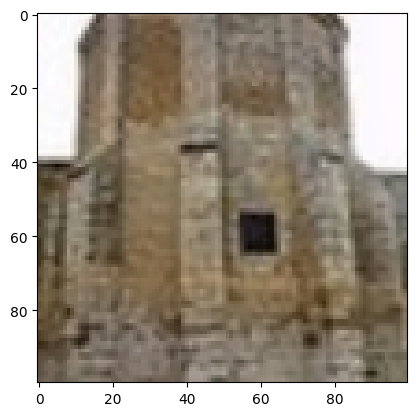

In [27]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[1].permute(1, 2, 0).numpy() * std + mean);

In [28]:
def training(model, loss_module, optimizer, train_dl,test_dl, num_epochs, device, scheduler=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    outputs = None
    pbar = tqdm(range(num_epochs))
    for _ in pbar:
        model.train()
        avgLoss = 0
        for x, y in train_dl:
            x = x.to(device) 
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_module(outputs, F.one_hot(y, num_classes=10).float())
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            model.eval()
            train_loss = []
            train_accuracy = []
            for x, y in train_dl:
                x = x.to(device) 
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = loss_module(outputs, F.one_hot(y, num_classes=10).float())
                train_accuracie = (torch.argmax(outputs, dim=1) == y).float().mean()
                train_loss.append(loss.item())
                train_accuracy.append(train_accuracie.item())
            train_losses.append(np.mean(train_loss))
            train_accuracies.append(np.mean(train_accuracy))
            test_loss = []
            test_accuracy = []
            for x, y in test_dl:
                x = x.to(device) 
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = loss_module(outputs, F.one_hot(y, num_classes=10).float())
                test_accuracie = (torch.argmax(outputs, dim=1) == y).float().mean()
                test_loss.append(loss.item())
                test_accuracy.append(train_accuracie.item())
            test_losses.append(np.mean(test_loss))
            test_accuracies.append(np.mean(test_accuracy))

        pbar.set_description(f"Loss is : [{train_losses[-1]}] val accuracy : {test_accuracies[-1]}")
    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [29]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report


In [30]:
def plot(train_losses, test_losses, train_accuracy, test_accuracy, model):
    plt.plot(train_losses, label="Training loss")
    plt.plot(test_losses, label="test loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.plot(train_accuracy, label="Training accuracy")
    plt.plot(test_accuracy, label="test accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    with torch.no_grad():
        model.eval()
        test_class_predictions = None
        test_labels = None
        t_class_predictions = []
        t_labels = []
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            preds = model(inputs)
            test_predictions = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
            test_class_predictions = test_predictions.argmax(axis=1)
            test_labels = labels.numpy()
            t_class_predictions = np.concatenate((t_class_predictions, test_class_predictions))
            t_labels = np.concatenate((t_labels, test_labels))
            
        cm = confusion_matrix(t_labels, t_class_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        tqdm.write("Classification Report:")
        tqdm.write(classification_report(t_labels, t_class_predictions))

In [31]:
num_classes = 10

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    def get_conv_kernels(self):
        conv_kernels = []
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                conv_kernels.append(layer.weight.data.clone())
        return conv_kernels


Loss is : [0.5348858841708009] val accuracy : 0.8515625: 100%|██████████| 30/30 [06:01<00:00, 12.04s/it]


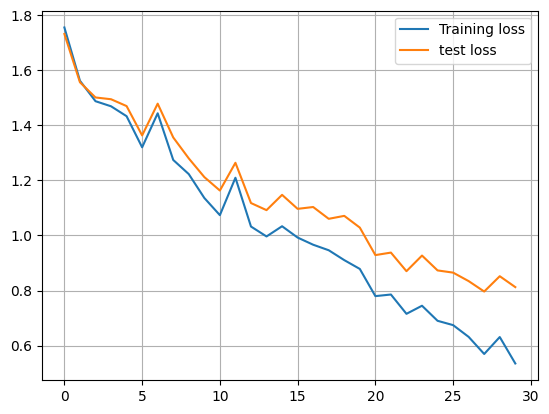

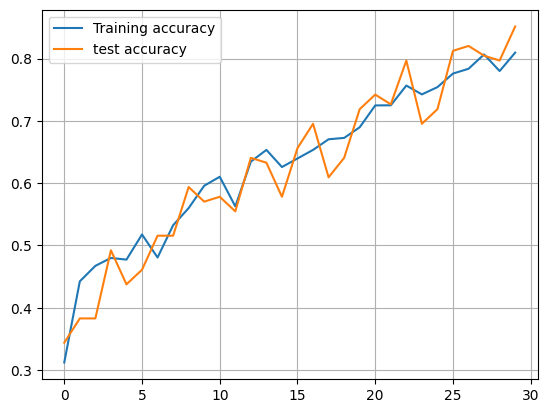

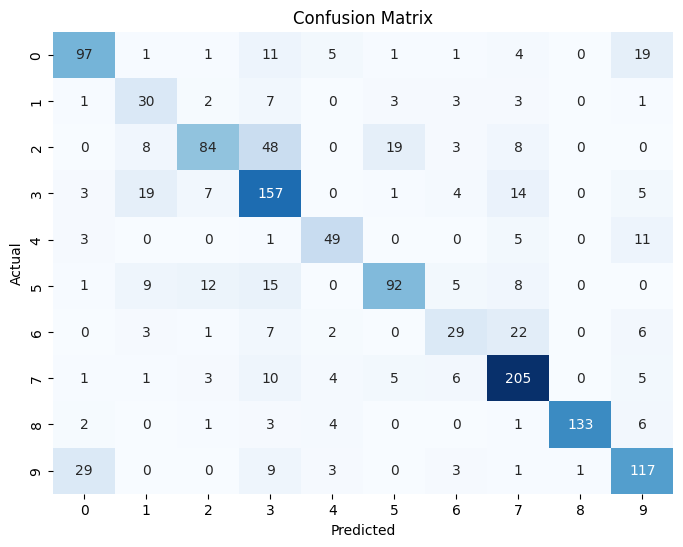

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70       140
         1.0       0.42      0.60      0.50        50
         2.0       0.76      0.49      0.60       170
         3.0       0.59      0.75      0.66       210
         4.0       0.73      0.71      0.72        69
         5.0       0.76      0.65      0.70       142
         6.0       0.54      0.41      0.47        70
         7.0       0.76      0.85      0.80       240
         8.0       0.99      0.89      0.94       150
         9.0       0.69      0.72      0.70       163

    accuracy                           0.71      1404
   macro avg       0.69      0.68      0.68      1404
weighted avg       0.72      0.71      0.71      1404



In [34]:
model = CNN(num_classes).to(device)
lr = 0.1
num_epochs = 30
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model, train_losses, train_accuracy, test_losses, test_accuracy = training(model, loss_module, optimizer, train_dataloader, val_dataloader, num_epochs, device)
plot(train_losses, test_losses, train_accuracy, test_accuracy, model)

In [39]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

        )
        self.fc1 = nn.Linear(8*100*100, 1024)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout()
        
        self.fc2 = nn.Linear(1024, 256)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout()
        
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
#         print(x.size())
        x = self.features(x)
        x = torch.flatten(x, 1)
#         print(x.size())

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)        
        return x
    def get_conv_kernels(self):
        conv_kernels = []
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                conv_kernels.append(layer.weight.data.clone())
        return conv_kernels

Loss is : [0.031234231593848114] val accuracy : 0.9921875: 100%|██████████| 30/30 [05:19<00:00, 10.65s/it]


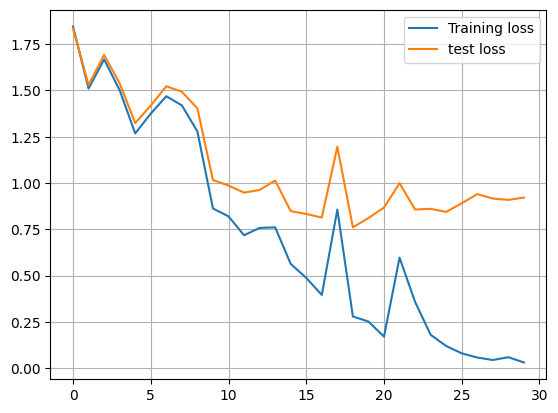

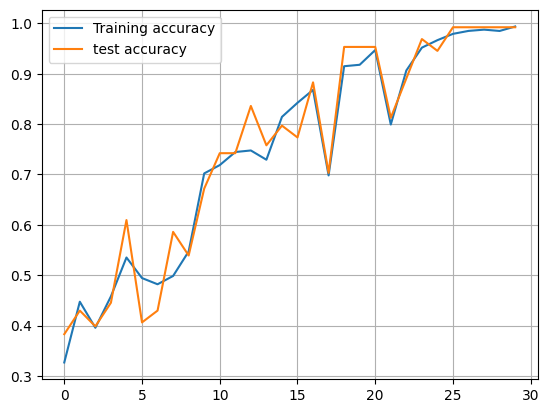

In [40]:
model = CNN(num_classes).to(device)
lr = 0.1
num_epochs = 30
loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model, train_losses, train_accuracy, test_losses, test_accuracy = training(model, loss_module, optimizer, train_dataloader, val_dataloader, num_epochs, device)
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.grid(True)
plt.show()
plt.plot(train_accuracy, label="Training accuracy")
plt.plot(test_accuracy, label="test accuracy")
plt.legend()
plt.grid(True)
plt.show()

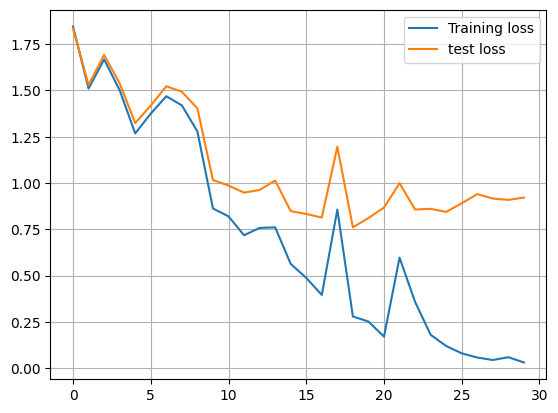

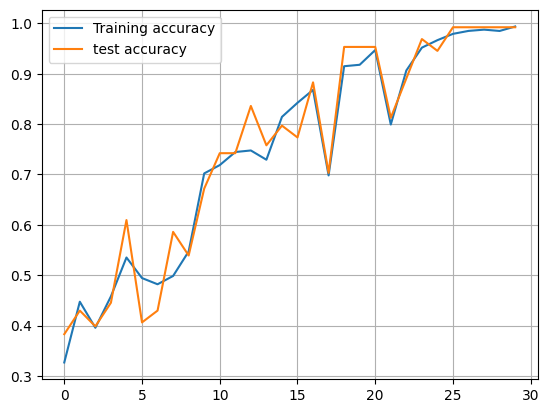

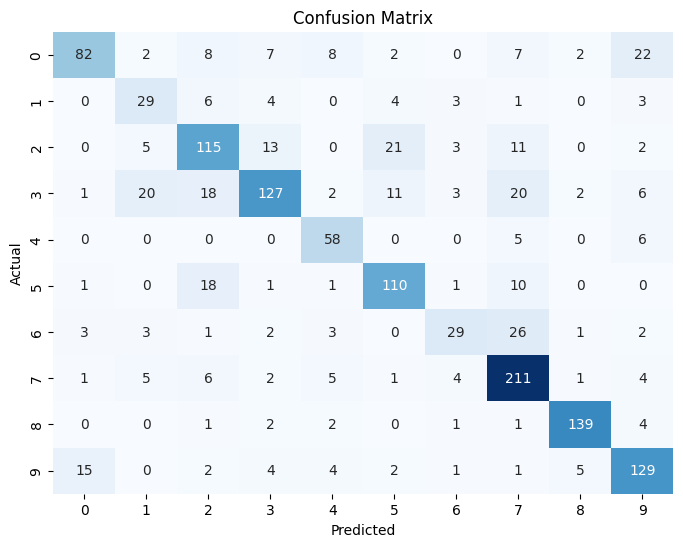

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.59      0.67       140
         1.0       0.45      0.58      0.51        50
         2.0       0.66      0.68      0.67       170
         3.0       0.78      0.60      0.68       210
         4.0       0.70      0.84      0.76        69
         5.0       0.73      0.77      0.75       142
         6.0       0.64      0.41      0.50        70
         7.0       0.72      0.88      0.79       240
         8.0       0.93      0.93      0.93       150
         9.0       0.72      0.79      0.76       163

    accuracy                           0.73      1404
   macro avg       0.71      0.71      0.70      1404
weighted avg       0.74      0.73      0.73      1404



In [41]:
plot(train_losses, test_losses, train_accuracy, test_accuracy, model)

In [111]:
conv_kernels = model.get_conv_kernels()


In [112]:
conv_kernels[0] = conv_kernels[0].to('cpu')

In [113]:
conv_kernels[0][0][1, :, :]

tensor([[-0.1475, -0.0822,  0.0942],
        [-0.0776,  0.1083,  0.1506],
        [-0.1744,  0.1958,  0.2089]])

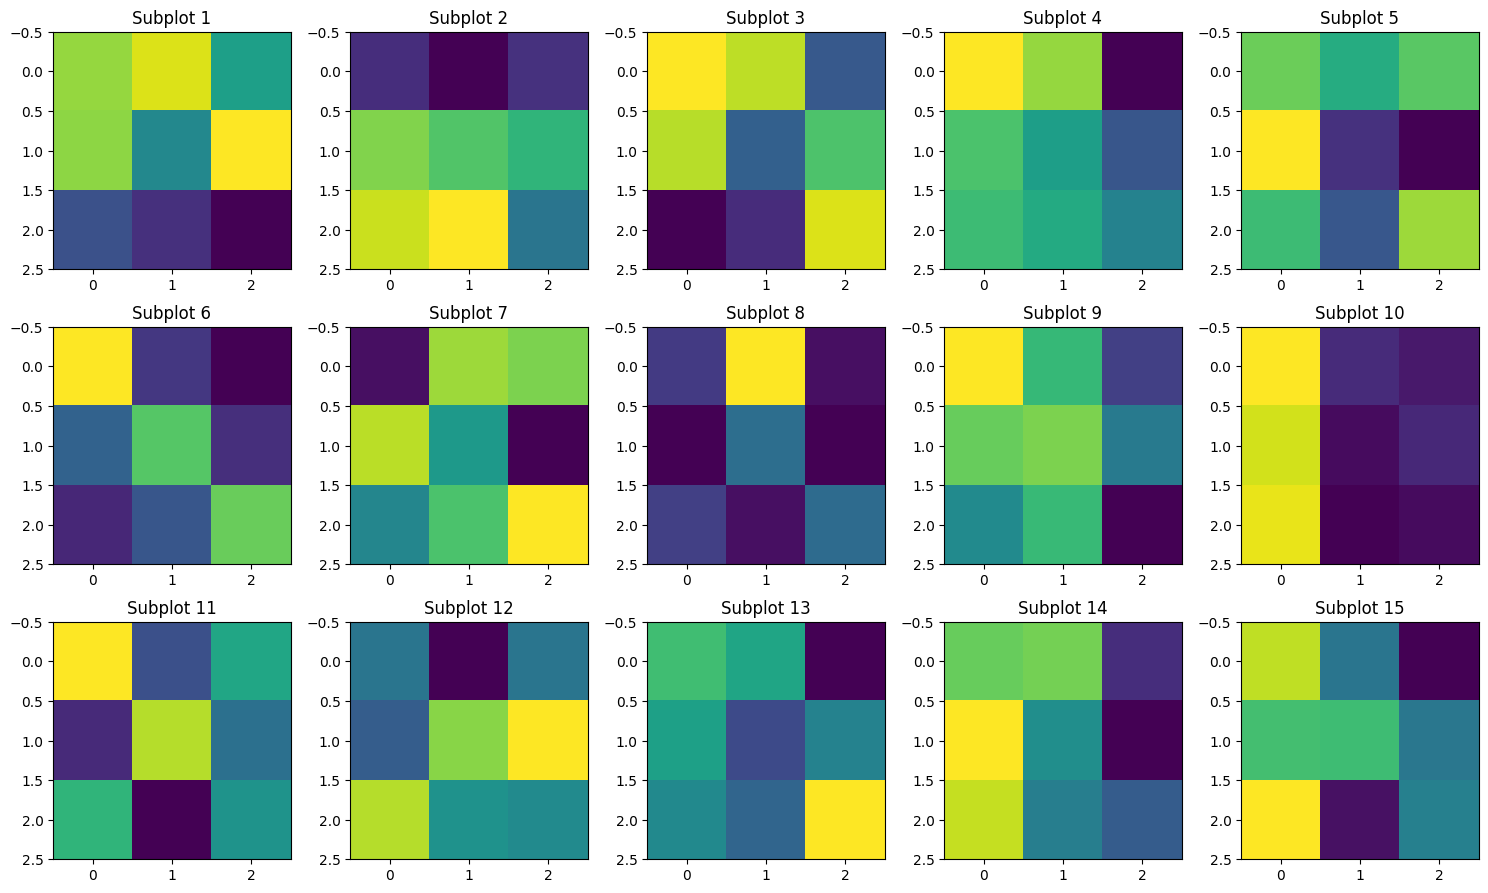

In [114]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9)) 
images = [
    conv_kernels[0][10][0, :, :],
    conv_kernels[0][20][0, :, :],
    conv_kernels[0][30][0, :, :],
    conv_kernels[0][40][0, :, :],
    conv_kernels[0][50][0, :, :],
    conv_kernels[0][10][1, :, :],
    conv_kernels[0][20][1, :, :],
    conv_kernels[0][30][1, :, :],
    conv_kernels[0][40][1, :, :],
    conv_kernels[0][50][1, :, :],
    conv_kernels[0][10][2, :, :],
    conv_kernels[0][20][2, :, :],
    conv_kernels[0][30][2, :, :],
    conv_kernels[0][40][2, :, :],
    conv_kernels[0][50][2, :, :]
    
]
for i, image in enumerate(images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image)
    axs[row, col].set_title(f'Subplot {i+1}') 


for i in range(len(images), 3 * 5):
    row = i // 5
    col = i % 5
    axs[row, col].axis('off')

plt.tight_layout() 
plt.show()

In [115]:
conv_kernels[2] = conv_kernels[2].to('cpu')

In [116]:
conv_kernels[2].size()

torch.Size([128, 64, 3, 3])

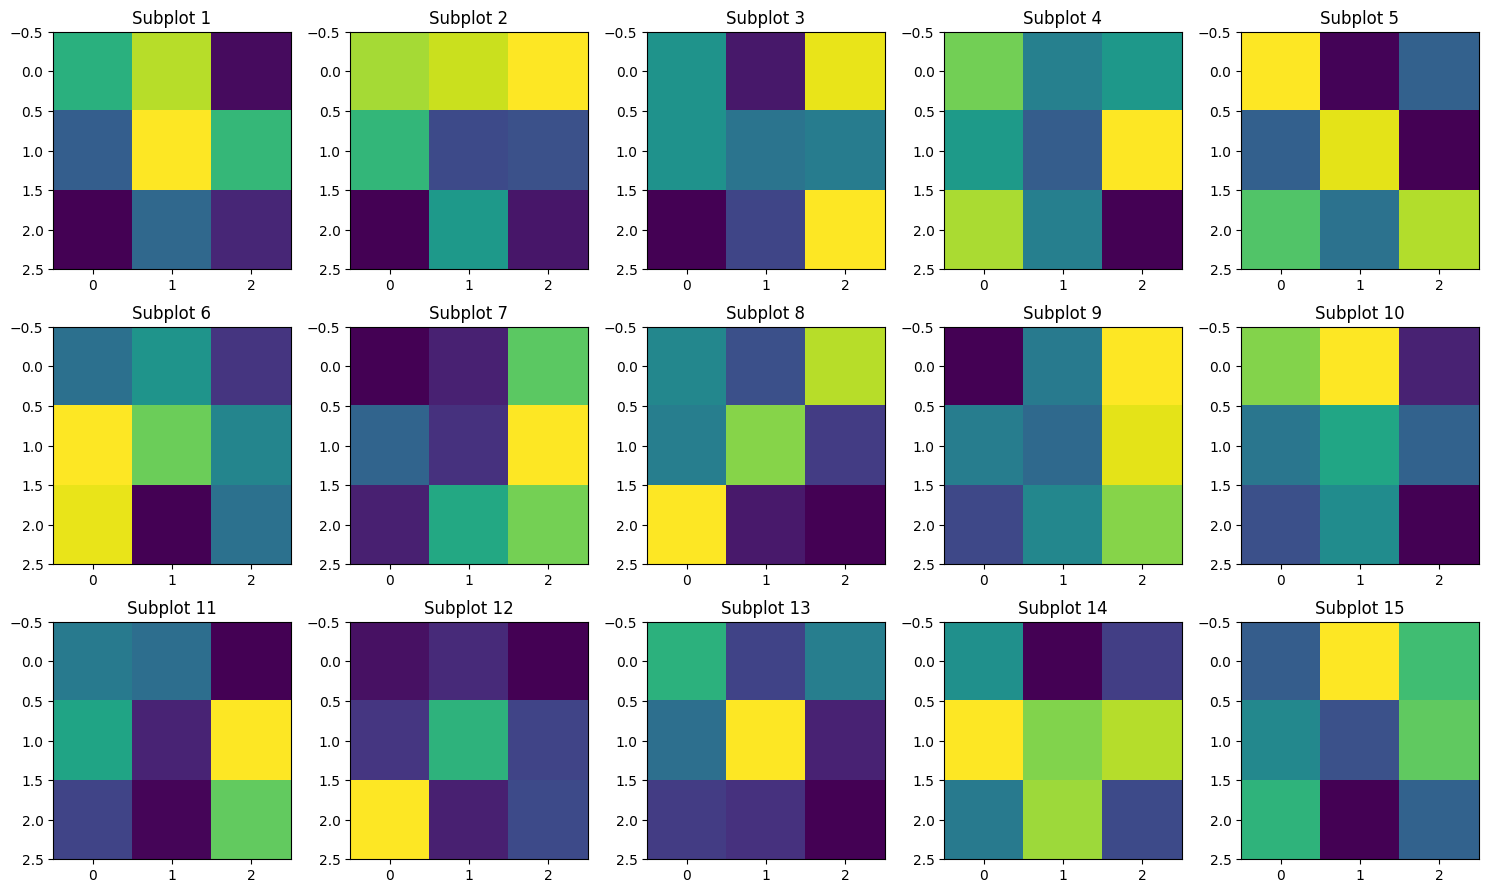

In [117]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9)) 
images = [
    conv_kernels[2][10][0, :, :],
    conv_kernels[2][10][10, :, :],
    conv_kernels[2][10][20, :, :],
    conv_kernels[2][10][30, :, :],
    conv_kernels[2][10][60, :, :],
    conv_kernels[2][30][0, :, :],
    conv_kernels[2][30][10, :, :],
    conv_kernels[2][30][20, :, :],
    conv_kernels[2][30][30, :, :],
    conv_kernels[2][30][60, :, :],
    conv_kernels[2][60][0, :, :],
    conv_kernels[2][60][10, :, :],
    conv_kernels[2][60][20, :, :],
    conv_kernels[2][60][30, :, :],
    conv_kernels[2][60][60, :, :]
    
]
for i, image in enumerate(images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image)
    axs[row, col].set_title(f'Subplot {i+1}') 


for i in range(len(images), 3 * 5):
    row = i // 5
    col = i % 5
    axs[row, col].axis('off')

plt.tight_layout() 
plt.show()

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))


In [104]:
conv_kernels[i][j][k].T

tensor([[-0.0071, -0.0638, -0.1262],
        [-0.1748, -0.1607,  0.1248],
        [ 0.0672,  0.0600,  0.1118]])

In [106]:
conv_kernels[0].size()

torch.Size([64, 3, 3, 3])

In [122]:
class Deconv(nn.Module):
    def __init__(self, custom_kernels):
        super(Deconv, self).__init__()

        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)

      
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)

        self.deconv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)

        self.relu2 = nn.ReLU(inplace=True)
        self.deconv3 = nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.load_custom_kernels(custom_kernels, [self.conv1, self.conv2, self.conv3])
        self.load_custom_kernels(custom_kernels, [self.deconv3, self.deconv2, self.deconv1])

    def load_custom_kernels(self, custom_kernels, seq):
        for idx, layer in enumerate(seq):
            if isinstance(layer, nn.ConvTranspose2d):
                layer.weight.data = torch.Tensor(custom_kernels[idx])

    def forward(self, x):
        x = self.conv1(x)
        size1 = x.size()
        x, in1 = self.pool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        size2 = x.size()
        x, in2 = self.pool2(x)
        x = self.relu2(x)

        x = self.conv3(x)

        x = self.deconv1(x)
        x = self.upsample1(x, in2, size2)
        x = self.deconv2(x)
        x = self.upsample2(x, in1, size1)
        x = self.deconv3(x)
        return x



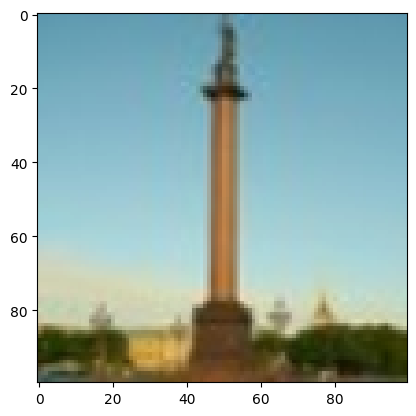

In [123]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[5].permute(1, 2, 0).numpy() * std + mean);

In [125]:
dec_model = Deconv(conv_kernels).to(device)

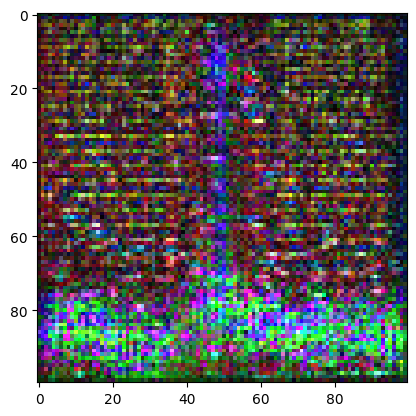

In [126]:
plt.imshow(abs(dec_model(X_batch.to(device))[5]).permute(1, 2, 0).detach().cpu().numpy())